# Data Science with Python and Dask
## Chapter 7: Visualizing DataFrames with Seaborn

### Section 7.2.1

In [1]:
# Listing 7.1
import dask.dataframe as dd
import pyarrow
from dask.diagnostics import ProgressBar
import os
import seaborn as sns
import matplotlib.pyplot as plt
import dask

#pd.set_option("string_storage", "pyarrow")
dask.config.set({"use_nullable_dtypes": True})
dask.config.set({"dataframe.convert-string": True}) # check if this is necessary, or?
dask.config.set({"dataframe.dtype_backend": "pyarrow"})
# Set working directory and read in the data
os.chdir('/Users/Abba/Documents/data-science-python-dask')

# Updated 6-AUG-2020
# In an earlier update in chapter 5, the index was dropped to solve an error writing the final parquet file using newer versions of Dask
# This got rid of the Citation Issued Month Year column, which is referenced multiple times in thie notebook
# Added a rename of the monthYear column to fix this 
nyc_data = dd.read_parquet('nyc_final', engine='pyarrow').rename(columns={'monthYear':'Citation Issued Month Year'})

In [2]:
# Listing 7.2
row_filter = ~nyc_data['Citation Issued Month Year'].isin(['07-2017','08-2017','09-2017','10-2017','11-2017','12-2017'])
nyc_data_filtered = nyc_data[row_filter]

citationsAndTemps = nyc_data_filtered.groupby('Citation Issued Month Year').agg({'Summons Number': 'count', 'Temp': 'mean'})

[########################################] | 100% Completed | 1.85 sms


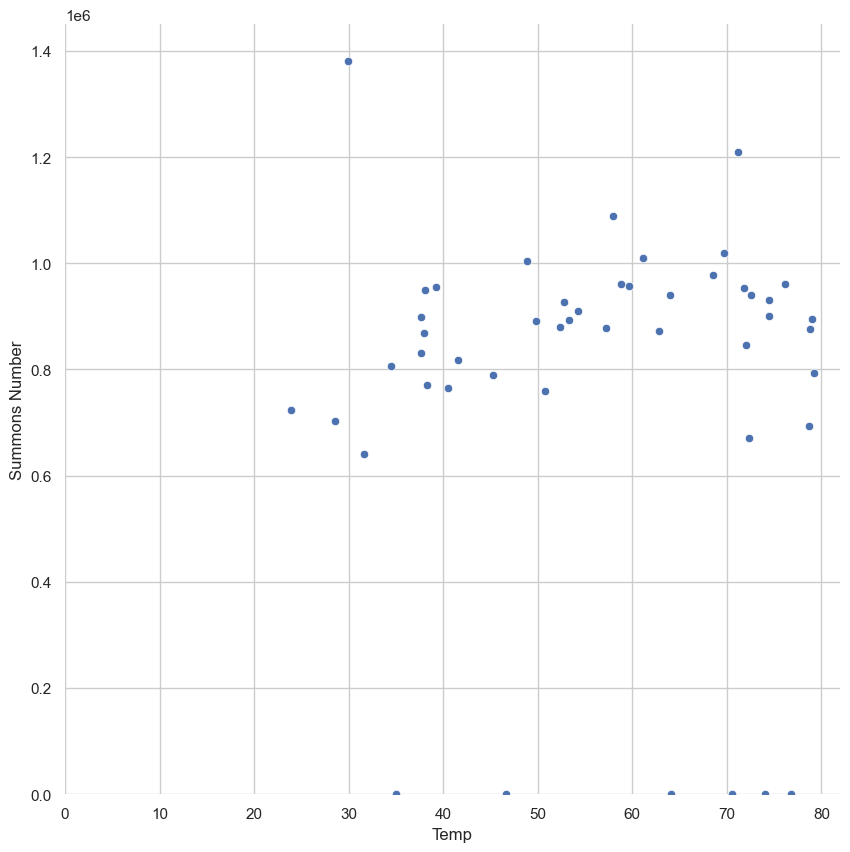

In [3]:
# Listing 7.3
# Plot a scatter plot of Temp vs. Number of Citations
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

with ProgressBar():
    sns.scatterplot(x="Temp", y="Summons Number",
                data=citationsAndTemps.compute(), ax=ax)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

### Section 7.2.2

[########################################] | 100% Completed | 1.77 sms


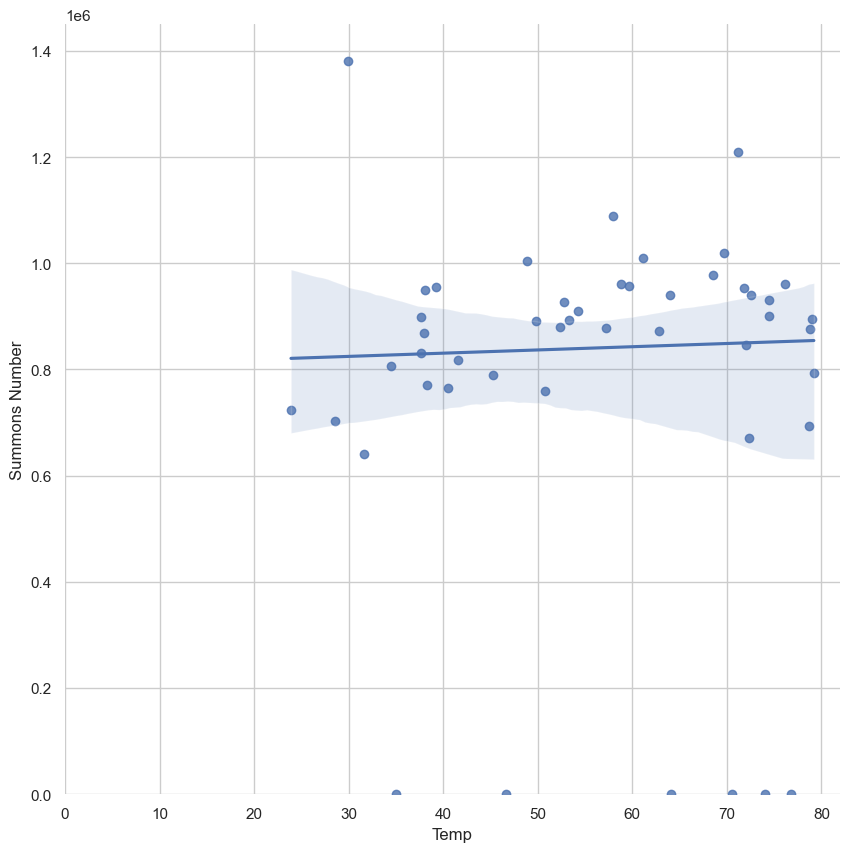

In [4]:
# Listing 7.4
# Add a robust regression line to the scatter plot using regplot
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

with ProgressBar():
    sns.regplot(x="Temp", y="Summons Number",
               data=citationsAndTemps.compute(), ax=ax,
               robust=True)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

### Section 7.2.3

[########################################] | 100% Completed | 1.83 sms


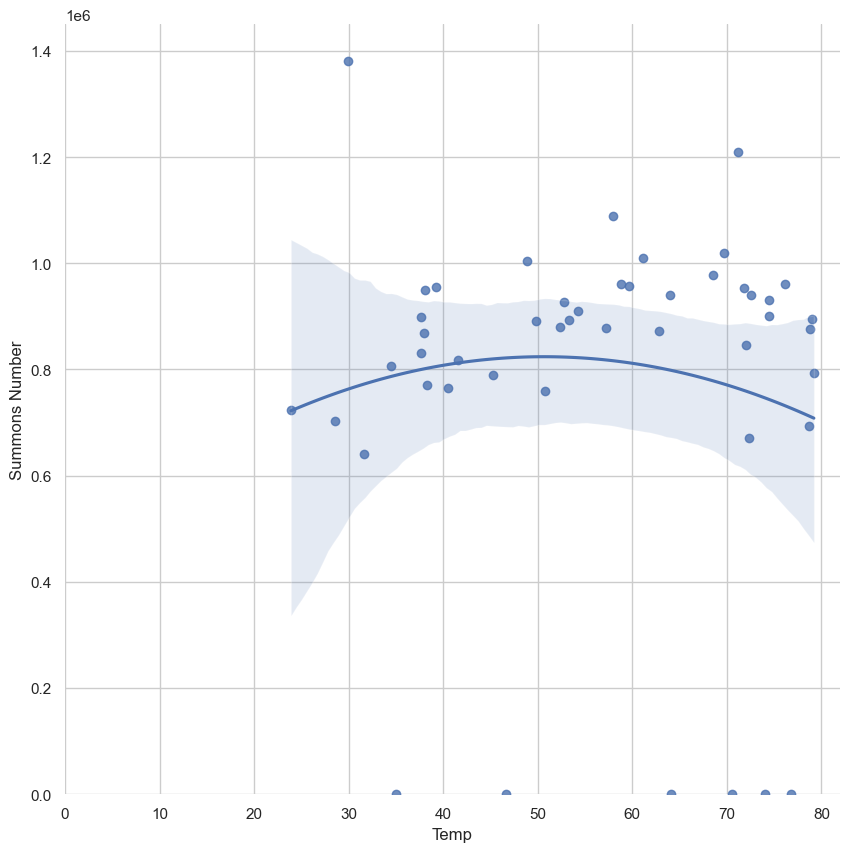

In [5]:
# Listing 7.5
# Try a non-linear fit by setting the order parameter to 2 (roughly parabolic shape)
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

with ProgressBar():
    sns.regplot(x="Temp", y="Summons Number",
               data=citationsAndTemps.compute(), ax=ax,
               order=2)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

### Section 7.3.1

In [6]:
# Listing 7.6
# Read in the data and filter down to the six most popular vehicle colors
nyc_data_withVehicleAge = dd.read_parquet('nyc_data_vehicleAge', engine='pyarrow')

row_filter = nyc_data_withVehicleAge['Vehicle Color'].isin(['BLACK','WHITE','GREY','RED','GREEN','BLUE'])
column_filter = ['Vehicle Age','Vehicle Color']

ages_and_colors = nyc_data_withVehicleAge[row_filter][column_filter]

In [7]:
# Listing 7.7
# Get a count of how many vehicle citations match our criteria
with ProgressBar():
    print(ages_and_colors.count().compute())

[########################################] | 100% Completed | 818.14 ms
Vehicle Age      4971199
Vehicle Color    4971199
dtype: int64


[########################################] | 100% Completed | 829.71 ms


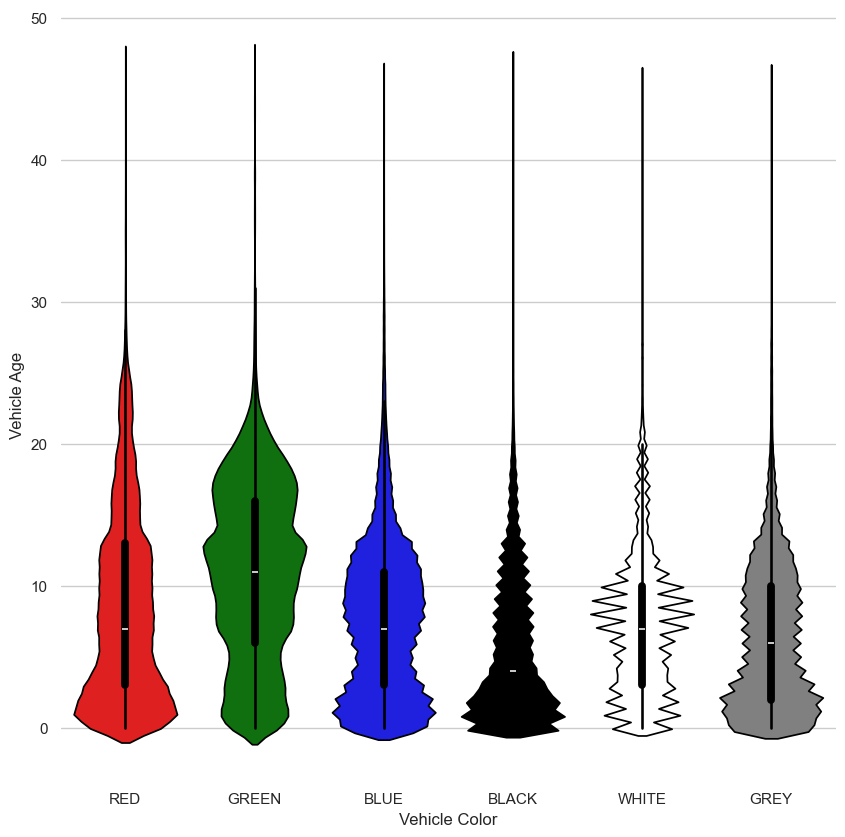

In [8]:
# Listing 7.8
# Plot a violinplot to show the distributions of vehicle ages grouped by vehicle color
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

group_order = ["RED", "GREEN", "BLUE", "BLACK", "WHITE", "GREY"]

with ProgressBar():
    sns.violinplot(x="Vehicle Color", y="Vehicle Age", data=ages_and_colors.compute(), order=group_order, palette=group_order, ax=ax)

### Section 7.3.2

[########################################] | 100% Completed | 946.44 ms


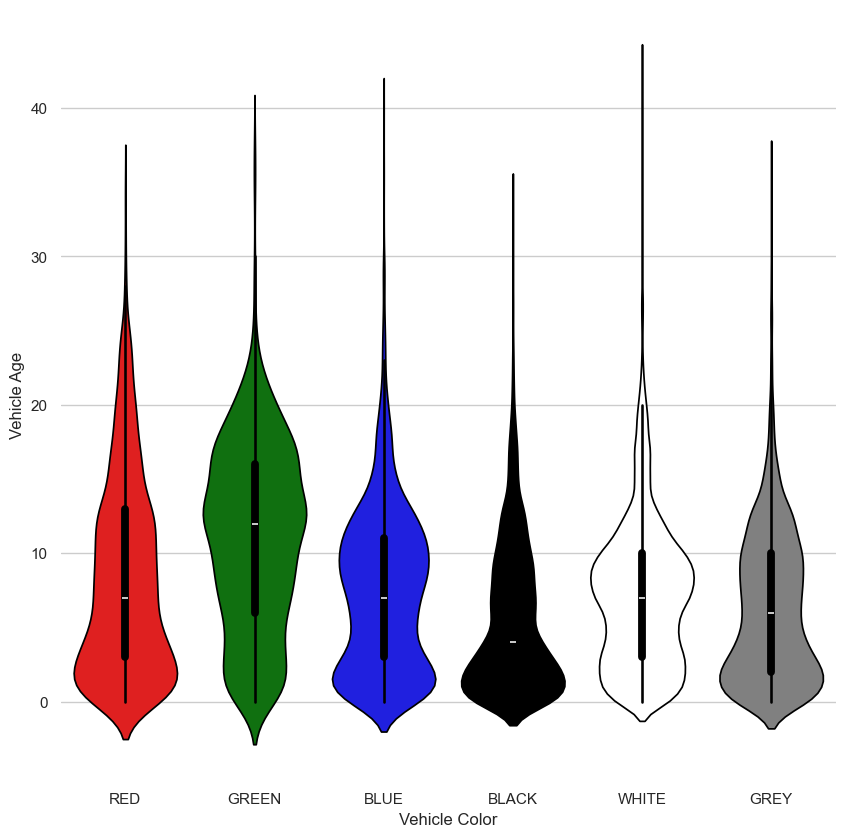

In [9]:
# Listing 7.9
# Plot a violinplot of a random sample
sample = ages_and_colors.sample(frac=0.01)

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

with ProgressBar():
    sns.violinplot(x="Vehicle Color", y="Vehicle Age", data=sample.compute(), order=group_order, palette=group_order, ax=ax)

### Section 7.4

In [10]:
# Listing 7.10
from datetime import datetime
nyc_data_filtered = nyc_data[nyc_data['Issue Date'] < datetime(2017,1,1)]

day_of_week = nyc_data_filtered['Issue Date'].apply(lambda x: x.strftime("%A"), meta='string[pyarrow]')

month_of_year = nyc_data_filtered['Issue Date'].apply(lambda x: x.strftime("%B"), meta='string[pyarrow]')

In [11]:
# Listing 7.11
# Add the columns back to the DataFrame
nyc_data_with_dates_raw = nyc_data_filtered.assign(DayOfWeek = day_of_week).assign(MonthOfYear = month_of_year)
column_map = {'DayOfWeek': 'Day of Week', 'MonthOfYear': 'Month of Year'}
nyc_data_with_dates = nyc_data_with_dates_raw.rename(columns=column_map)


In [14]:
nyc_data_with_dates['Day of Week'] = nyc_data_with_dates['Day of Week'].astype('string[pyarrow]')

In [15]:
nyc_data_with_dates['Month of Year'] = nyc_data_with_dates['Month of Year'].astype('string[pyarrow]')

In [17]:
# Listing 7.12
# Count up the summons by month of year/day of week
with ProgressBar():
    summons_by_mydw = nyc_data_with_dates.groupby(['Day of Week', 'Month of Year'])['Summons Number'].count().compute()

[########################################] | 100% Completed | 322.42 s


heatmap_data = summons_by_mydw.reset_index().pivot("Month of Year","Day of Week","Summons Number")

In [26]:
# Listing 7.13
# Create a pivot table from the result
heatmap_data = summons_by_mydw.reset_index().pivot_table(index="Month of Year",columns= "Day of Week", values="Summons Number",aggfunc='mean')

In [33]:
heatmap_data = heatmap_data.astype('int32')
display(heatmap_data.head())

Day of Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Month of Year,,,,,,,
April,454893,402421,283372,103265,483788,477737,477164
August,442856,440429,274653,120177,438175,453000,419837
December,379487,370772,206349,93357,411904,435349,397688
February,349991,343922,239021,96796,396956,400400,370270
January,567688,415159,322209,115416,580092,439979,451348


<Axes: xlabel='Day of Week', ylabel='Month of Year'>

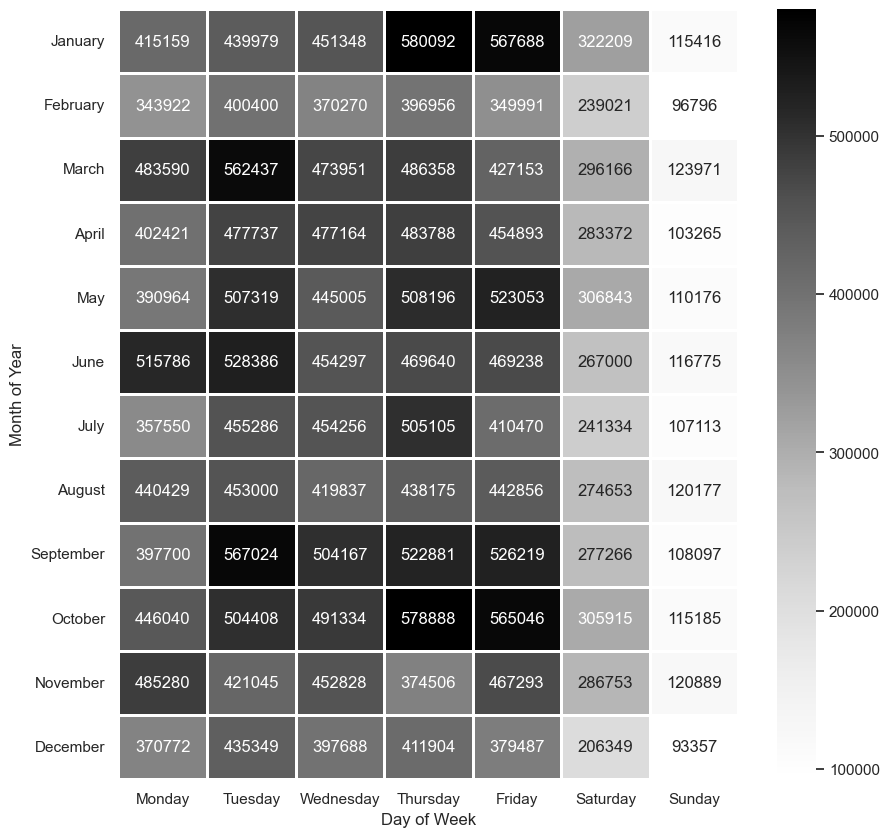

In [34]:
# Listing 7.14
# Create a list of months and weekdays for sorting the data in the heatmap
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Draw a heatmap with Day of Week on the x axis and Month of Year on the Y axis
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(heatmap_data.loc[months,weekdays], annot=True, fmt="d", linewidths=1, cmap='Greys', ax=ax)